In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

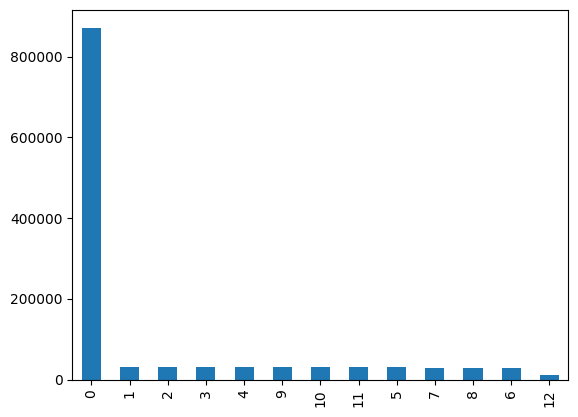

In [4]:
pd.value_counts(df['Activity']).plot.bar()

In [5]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [6]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [7]:
workers_info=[]
enery_for_edge_at_start=100000
#data,cluster no ,edge score,model - coeff,model -intercept,energy consumed,acc
for i in range(5):
    for j in range(5):
        worker_data=pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id=i
        worker_score=0
        worker_coef=0
        worker_intercept=0
        worker_energy=[]
        energy_acc=[]
        energy=enery_for_edge_at_start
        workers_info.append([worker_data,worker_id,worker_coef,worker_score,worker_intercept,worker_energy,energy_acc,energy])

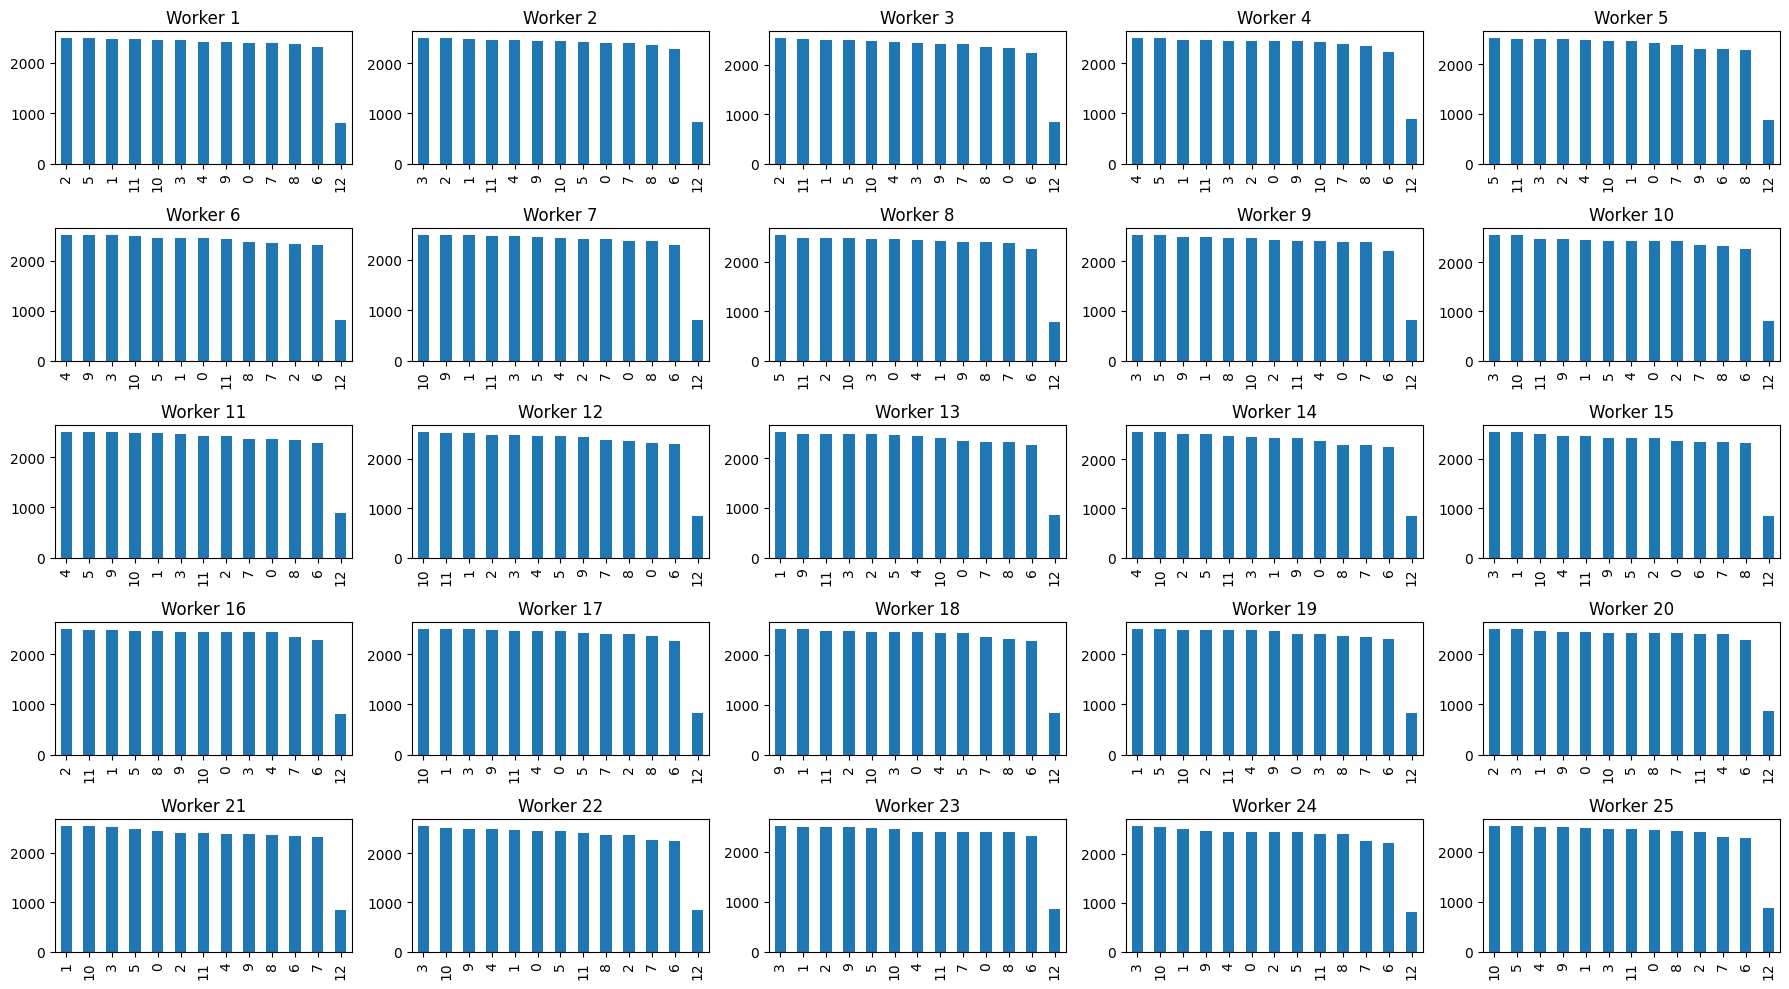

In [8]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()


In [9]:
# def extract(message):
#     message_pack_container = msgpack.unpackb(message)
#     compressed_byte_array = message_pack_container[0]
#     decompressed_byte_array = gzip.decompress(compressed_byte_array)

#     try:
#         data = msgpack.unpackb(decompressed_byte_array)
#         if isinstance(data, tuple):
#             weights, shape = data
#             return np.array(weights), np.array(shape)
#         else:
#             # If only weights are packed (without shape information)
#             return np.array(data), None
#     except ValueError:
#         # In case shape information is not available
#         weights = msgpack.unpackb(decompressed_byte_array)
#         return np.array(weights), None

import msgpack
import gzip
import numpy as np
import joblib
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        message_pack_container = msgpack.unpackb(message)
        compressed_byte_array = message_pack_container[0]
        decompressed_byte_array = gzip.decompress(compressed_byte_array)

        try:
            # Use joblib.load to handle non-linear models like RandomForestClassifier
            model = joblib.load(io.BytesIO(decompressed_byte_array))
            return model, None
        except Exception as e:
            print(f"Error loading model: {e}")
            return None, None
    except Exception as e:
        print(f"Error in extracting: {e}")
        return None, None

def compress(model):
    try:
        # Serialize the model using joblib
        model_serialized = joblib.dump(model)
        # Compress the serialized model
        compressed_model = zlib.compress(model_serialized)
        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception as e:
        print(f"Error compressing model: {e}")
        return None


In [10]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power=1
    #energy=power *time=time=data/power=data
    return data
def terminate(accuracy,best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

# Modify the local_worker_training function
def local_worker_training(worker_num, global_model):
    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize variables before the if-else block
    energy_comsuption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_comsuption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) + sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])
        print(f"Debug: Worker {worker_num}, sample_weights: {sample_weights}")

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        # Ensure that sample_weights have the correct shape
        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train):
            sample_weights = np.repeat(sample_weights, len(lX_train) // len(sample_weights) + 1)[:len(lX_train)]
            print(f"Debug: Worker {worker_num}, updated sample_weights: {sample_weights}")

    else:
        # Train the model on the entire dataset
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_comsuption_in_local += max_global_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_comsuption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_comsuption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_global_rounds, "energy remaining:", workers_info[worker_num][7])


In [11]:
def training_workers(global_model):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [12]:
def cal_batter_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100

In [13]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [14]:
# def global_aggregation():
#     training_workers()
#     cal_edge_score()
#     cal_clusters_head()

#     # Use RandomForestClassifier instead of SGDClassifier
#     global_model = RandomForestClassifier(n_estimators=100, random_state=42)

#     # Initialize arrays to store aggregated coefficients and intercepts
#     first_worker_model = workers_info[0][2]
#     if first_worker_model:
#         avg_coef_ = np.zeros_like(extract(first_worker_model))
#         avg_intercept_ = np.zeros_like(extract(workers_info[0][4]))

#         num_contributing_workers = 0
#         for i in range(num_of_clusters):
#             worker_model = workers_info[i][2]
#             if worker_model:
#                 avg_coef_ += extract(worker_model)
#                 avg_intercept_ += extract(workers_info[i][4])
#                 num_contributing_workers += 1

#         if num_contributing_workers > 0:
#             # Set the global model's coefficients and intercept to the averaged values
#             global_model.coef_ = avg_coef_ / num_contributing_workers
#             global_model.intercept_ = avg_intercept_ / num_contributing_workers

#     return global_model

from sklearn.ensemble import RandomForestClassifier
import copy

def global_aggregation():
    training_workers()
    cal_edge_score()
    cal_clusters_head()

    # Use RandomForestClassifier instead of SGDClassifier
    global_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a list to store aggregated trees
    aggregated_trees = []

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model = workers_info[i][2]

        if worker_model:
            # Extract the trees from the worker's RandomForestClassifier
            trees = extract(worker_model).estimators_

            # Aggregate the trees
            if num_contributing_workers == 0:
                # If it's the first worker, simply copy the trees
                aggregated_trees = copy.deepcopy(trees)
            else:
                # Aggregate subsequent trees
                for j in range(len(aggregated_trees)):
                    aggregated_trees[j].tree_ += trees[j].tree_

            num_contributing_workers += 1

    # Normalize the aggregated trees by dividing the tree values by the number of contributing workers
    if num_contributing_workers > 0:
        for tree in aggregated_trees:
            tree.tree_ = tree.tree_ / num_contributing_workers

    # Set the aggregated trees to the global model
    global_model.estimators_ = aggregated_trees

    return global_model


In [15]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

max_global_rounds = 15
acc = []

for i in range(max_global_rounds):
    global_model = global_aggregation()
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)

# Assuming you are calling training_workers inside global_aggregation
# Add this line at the end of global_aggregation
# training_workers(global_model)


local worker: 0 acc: 0.95 round no: 15 energy remaining: 99999.85
local worker: 1 acc: 0.954 round no: 15 energy remaining: 99999.85
local worker: 2 acc: 0.9501666666666667 round no: 15 energy remaining: 99999.85
local worker: 3 acc: 0.9455 round no: 15 energy remaining: 99999.85
local worker: 4 acc: 0.9511666666666667 round no: 15 energy remaining: 99999.85
local worker: 5 acc: 0.9475 round no: 15 energy remaining: 99999.85
local worker: 6 acc: 0.9521666666666667 round no: 15 energy remaining: 99999.85
local worker: 7 acc: 0.9496666666666667 round no: 15 energy remaining: 99999.85
local worker: 8 acc: 0.955 round no: 15 energy remaining: 99999.85
local worker: 9 acc: 0.9513333333333334 round no: 15 energy remaining: 99999.85
local worker: 10 acc: 0.9503333333333334 round no: 15 energy remaining: 99999.85
local worker: 11 acc: 0.9506666666666667 round no: 15 energy remaining: 99999.85
local worker: 12 acc: 0.9563333333333334 round no: 15 energy remaining: 99999.85
local worker: 13 acc:

KeyboardInterrupt: 

In [ ]:
total_energy_per_round=[]
energy_per_round=[]
total_energy=0
for i in range(15):
    energy=0
    for j in range(num_of_workers):
        total_energy+=workers_info[j][5][i]
        energy+=workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
energy_per_round

IndexError: list index out of range

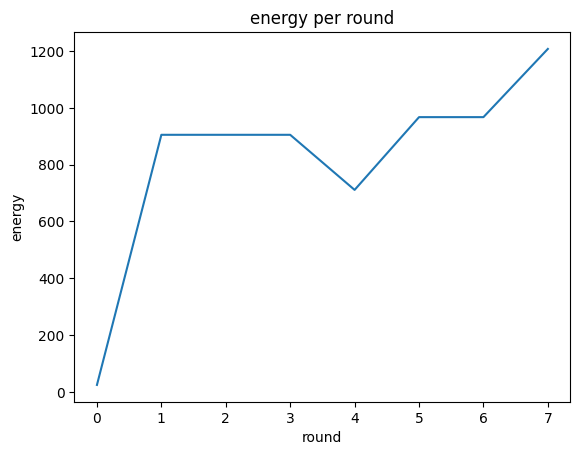

In [ ]:
plt.plot(energy_per_round)
plt.xlabel("round")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()

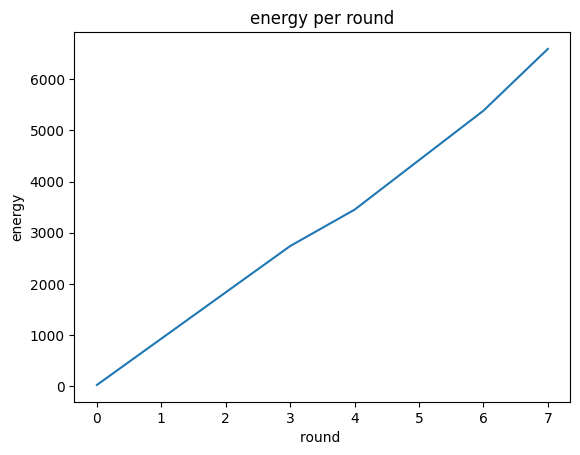

In [ ]:
plt.plot(total_energy_per_round)
plt.xlabel("round ")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()